This project uses synthetic generated data from https://infinity.ai/ \
Github https://github.com/toinfinityai/infinity-datasets/tree/main 


#### Parameters
num_reps:  Number of exercise repetitions in the returned time series data.\
watch_location:  Wrist where device is placed (left or right).\
crown_orientation:  Which side the watch crown points (from first-person perspective; left or right).\
ref_xy_rotation:  Rotation (in XY plane) of the reference orientation in radians (simulates the xArbitraryZVertical reference in the Apple CoreMotion SDK).\
rel_baseline_speed:  Baseline speed of animation, relative to default (natural) speed.\
max_rel_speed_change:  Maximum speed change introduced, relative to baseline speed.\
trim_start_frac:  Fraction of seed animation (from start to midpoint) to truncate at the start.\
trim_end_frac:  Fraction of seed animation (from start to midpoint) to truncate at the end.\
kinematic_noise_factor:  Scaling factor used to adjust the amount of kinematic noise added in the simulated movement.\
wrist_offset_deg:  Fixed rotation offset applied to the supination/pronation axis of the wrists, in degrees. Negative values correspond to supination.\
randomize_body_shape:  If True, the avatar's body shape is randomized.\
frames_per_second:  Sampling rate of exported time series and video.\
image_width:  Width dimension of the rendered video, in pixels.\
image_height:  Height dimension of the rendered video, in pixels.


In [ ]:
import glob
import pandas as pd
import json
from pandas import json_normalize
import os
import numpy as np

In [1]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None) 
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

In [78]:
#function for retrieving multiple csv/json files

def create_combined_dataframe(directory):
    """
    Create a combined DataFrame for each set of CSV and JSON files in the specified directory.

    Parameters:
    - directory (str): The directory containing CSV and JSON files.

    Returns:
    - List[pd.DataFrame]: A list of DataFrames where each DataFrame combines CSV and JSON data, with each parameter in the JSON file having its own column.
    """
    combined_dfs = []
    
    # creates list of file names matching the pattern '*.csv' in the specified directory
    csv_files = glob.glob(f'{directory}/*.csv')

    # Process each CSV file
    for csv_file in csv_files:
        csv_df = pd.read_csv(csv_file, index_col=0)
        
        #creating column assigning rep numbers
        csv_df['rep_num'] = np.floor(csv_df['rep_count_from_start']+1).astype(int)
        
        #creating column with average rep time
        csv_df['avg_rep_time'] = csv_df['time'].max()/csv_df['rep_num'].max()

        # json file path
        json_file = os.path.splitext(csv_file)[0] + '_params.json'

        # Read and normalize json file, create df
        with open(json_file, 'r') as f:
            json_data = json.load(f)

        json_df = json_normalize(json_data)
        json_df.columns = [col.replace('params.', '') for col in json_df.columns]
        json_df = pd.concat([json_df] * len(csv_df), ignore_index=True)

        #combined data frames
        combined_df = pd.concat([json_df, csv_df], axis=1)
        combined_dfs.append(combined_df)

    return combined_dfs

In [92]:
#creating list of armraise dataframes
armraise_path = '../data/basic_motions/armraise'
armraise_dataframes = create_combined_dataframe(armraise_path)

In [93]:
armraise_dataframes[50]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33,rep_num,avg_rep_time
0,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,0.466667,0.000000,0.879822,0.00,-0.300039,-0.317902,-0.899397,0.902789,-0.399185,-0.160074,-0.308138,-0.859994,0.406769,1,1.875
1,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,0.492401,0.025734,0.879822,0.05,-0.345138,-0.352772,-0.869731,0.881660,-0.439590,-0.171569,-0.321800,-0.826022,0.462744,1,1.875
2,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,0.518163,0.051496,0.879822,0.10,-0.404278,-0.396585,-0.824184,0.853913,-0.486515,-0.184757,-0.327706,-0.778475,0.535336,1,1.875
3,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,0.543954,0.077288,0.879822,0.15,-0.459750,-0.434626,-0.774422,0.829584,-0.521379,-0.199886,-0.316892,-0.734346,0.600263,1,1.875
4,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,0.569774,0.103108,0.879822,0.20,-0.528433,-0.478566,-0.701237,0.798216,-0.561390,-0.218387,-0.289154,-0.675141,0.678656,1,1.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,10.307658,9.840991,0.879822,18.55,-0.587461,-0.661885,-0.465616,0.794324,-0.581624,-0.175394,-0.154723,-0.472887,0.867432,10,1.875
372,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,10.333505,9.866838,0.879822,18.60,-0.520259,-0.618666,-0.588712,0.824290,-0.544046,-0.156717,-0.223331,-0.566803,0.793005,10,1.875
373,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,10.359340,9.892673,0.879822,18.65,-0.449202,-0.562834,-0.693856,0.849923,-0.508602,-0.137677,-0.275407,-0.651569,0.706831,10,1.875
374,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,-11.826704,False,True,20,480,480,1984524181,1.0,100,10.385163,9.918496,0.879822,18.70,-0.395598,-0.513072,-0.761748,0.866176,-0.484185,-0.123710,-0.305355,-0.708747,0.635953,10,1.875


In [94]:
#setting up the rest of the dataframes
bicepcurl_path = '../data/basic_motions/bicepcurl'
bicepcurl_dataframes = create_combined_dataframe(bicepcurl_path)

birddog_path = '../data/basic_motions/birddog'
birddog_dataframes = create_combined_dataframe(birddog_path)

burpee_path = '../data/basic_motions/burpee'
burpee_dataframes = create_combined_dataframe(burpee_path)

crunch_path = '../data/basic_motions/crunch'
crunch_dataframes = create_combined_dataframe(crunch_path)

hammercurl_path = '../data/basic_motions/hammercurl'
hammercurl_dataframes = create_combined_dataframe(hammercurl_path)

overheadpress_path = '../data/basic_motions/overheadpress'
overheadpress_dataframes = create_combined_dataframe(overheadpress_path)

pushup_path = '../data/basic_motions/pushup'
pushup_dataframes = create_combined_dataframe(pushup_path)

tricepkickback_left_path = '../data/basic_motions/tricepkickback_left'
tricepkickback_left_dataframes = create_combined_dataframe(tricepkickback_left_path)

tricepkickback_right_path = '../data/basic_motions/tricepkickback_right'
tricepkickback_right_dataframes = create_combined_dataframe(tricepkickback_right_path)

vup_path = '../data/basic_motions/vup'
vup_dataframes = create_combined_dataframe(vup_path)

In [95]:
armraise_dataframes[0].head(5)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33,rep_num,avg_rep_time
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,4.818261,0.00,0.313452,-0.218860,-0.924039,0.097586,0.975350,-0.197910,0.944576,-0.028138,0.327084,1,2.970833
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,4.818261,0.05,0.319075,-0.216120,-0.922758,0.092488,0.976105,-0.196634,0.943206,-0.022603,0.331439,1,2.970833
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,4.818261,0.10,0.331619,-0.214452,-0.918716,0.085394,0.976647,-0.197151,0.939541,-0.013074,0.342188,1,2.970833
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,4.818261,0.15,0.350453,-0.213280,-0.911973,0.077130,0.976991,-0.198847,0.933399,-0.000654,0.358839,1,2.970833
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,4.818261,0.20,0.379883,-0.213341,-0.900097,0.067529,0.976841,-0.203030,0.922566,0.016345,0.385492,1,2.970833


## Learning about changing rotational transformation matrix to roll-pitch-yaw

There are many csv's to import, but I am just looking at one exercise right now while I learn about converting a rotational matrix to roll-pitch-yaw. I will import the rest afterwards.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_euler.html \
https://eigen.tuxfamily.org/dox/group__Geometry__Module.html#title40 \
https://github.com/zivid/zivid-python-samples/blob/master/source/applications/advanced/hand_eye_calibration/pose_conversions.py 

In [96]:
#fuction to convert the rotation matrix to euler angles

import pandas as pd
from scipy.spatial.transform import Rotation as R

def add_euler_columns(df):
    rotation_matrix_columns = [
        'rotation_matrix_m11', 'rotation_matrix_m12', 'rotation_matrix_m13',
        'rotation_matrix_m21', 'rotation_matrix_m22', 'rotation_matrix_m23',
        'rotation_matrix_m31', 'rotation_matrix_m32', 'rotation_matrix_m33'
    ]

    rotation_matrices = df[rotation_matrix_columns].values.reshape(-1, 3, 3)
    euler_angles = R.from_matrix(rotation_matrices).as_euler("xyz")

    euler_df = pd.DataFrame(euler_angles, columns=['euler_x', 'euler_y', 'euler_z'])
    
    
    df = df.drop(rotation_matrix_columns, axis=1)
    df = pd.concat([df, euler_df], axis=1)

    return df

In [97]:
# Update each DataFrame in the list with euler angles instead of rotation matrix
for i in range(len(armraise_dataframes)):
    armraise_dataframes[i] = add_euler_columns(armraise_dataframes[i])


In [98]:
armraise_dataframes[0].head(5)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,4.818261,0.00,1,2.970833,-0.085816,-1.236302,0.301816
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,4.818261,0.05,1,2.970833,-0.068092,-1.232152,0.282132
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,4.818261,0.10,1,2.970833,-0.038189,-1.221286,0.252032
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,4.818261,0.15,1,2.970833,-0.001822,-1.203772,0.216632
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,4.818261,0.20,1,2.970833,0.042375,-1.174680,0.175925


In [99]:
# Update each DataFrame in the list with euler angles instead of rotation matrix

for i in range(len(bicepcurl_dataframes)):
    bicepcurl_dataframes[i] = add_euler_columns(bicepcurl_dataframes[i])
    
for i in range(len(birddog_dataframes)):
    birddog_dataframes[i] = add_euler_columns(birddog_dataframes[i])
    
for i in range(len(burpee_dataframes)):
    burpee_dataframes[i] = add_euler_columns(burpee_dataframes[i])

for i in range(len(crunch_dataframes)):
    crunch_dataframes[i] = add_euler_columns(crunch_dataframes[i])
    
for i in range(len(hammercurl_dataframes)):
    hammercurl_dataframes[i] = add_euler_columns(hammercurl_dataframes[i])
    
for i in range(len(overheadpress_dataframes)):
    overheadpress_dataframes[i] = add_euler_columns(overheadpress_dataframes[i])
    
for i in range(len(pushup_dataframes)):
    pushup_dataframes[i] = add_euler_columns(pushup_dataframes[i])
    
for i in range(len(tricepkickback_left_dataframes)):
    tricepkickback_left_dataframes[i] = add_euler_columns(tricepkickback_left_dataframes[i])
    
for i in range(len(tricepkickback_right_dataframes)):
    tricepkickback_right_dataframes[i] = add_euler_columns(tricepkickback_right_dataframes[i])
    
for i in range(len(vup_dataframes)):
    vup_dataframes[i] = add_euler_columns(vup_dataframes[i])

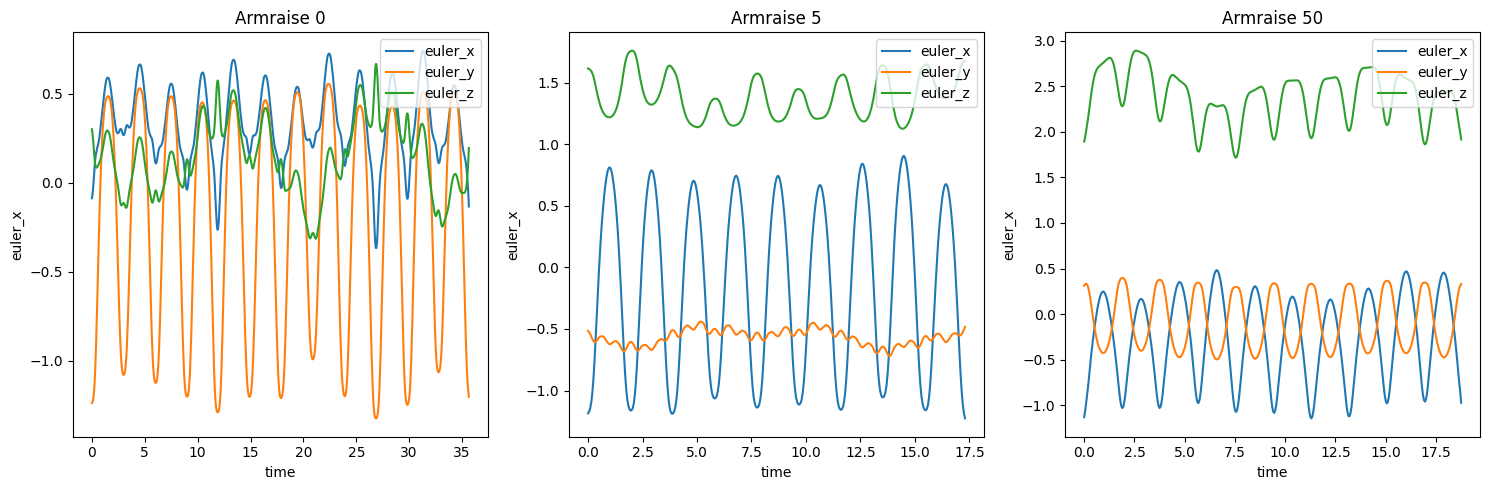

In [100]:
#plotting euler angles armraises

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Armraise 50')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Armraise 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Armraise 0')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()


In [87]:
# scales are different at this time, can I scale these? do I need to?

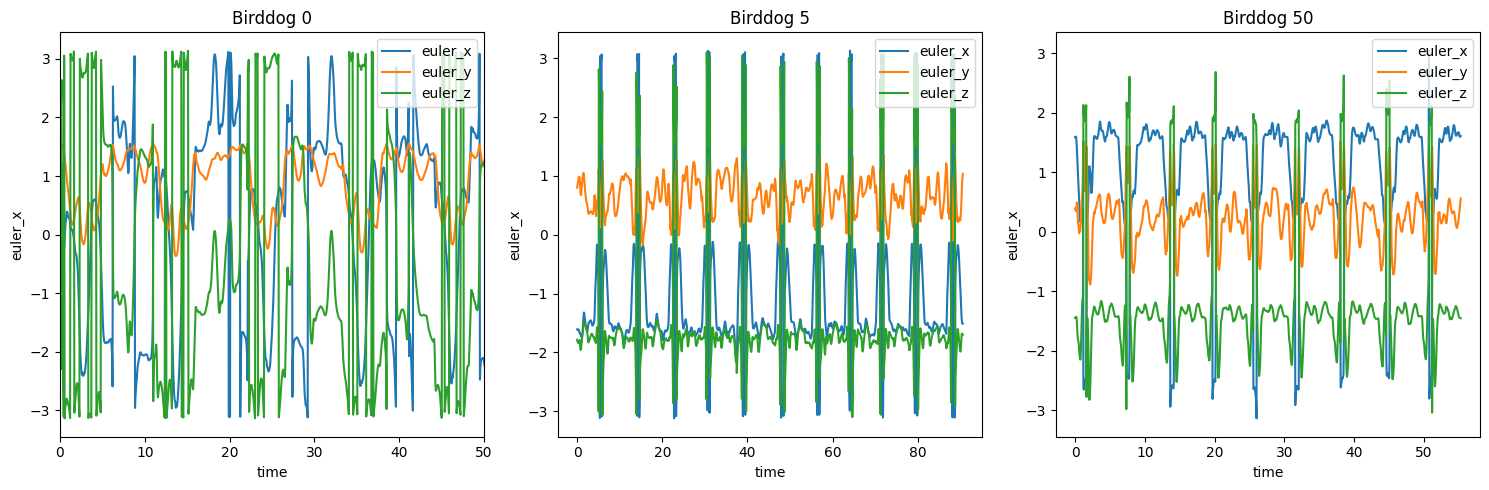

In [88]:
#plotting euler angles birddog

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[0].set_xlim(0, 50)
axes[2].set_title('Birddog 50')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

import seaborn as sns
import matplotlib.pyplot as plt

# Plot for armraise_dataframes[5]
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 0')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()

In order to maintain an even amount of data from each set, I will take the smallest number of entries from all the datasets and use that number to take even spaced data from the longer datasets. For this test \
I used 25 rows, as at this point I thought that was close to my lowest number of rows per rep. I will soon be disappointed that this is not true.

Shortly after creating the functions to even out the dataset lengths by selecting a specific number of rows per rep, some errors notified me that 25 rows per rep was not attainable in all of the dataframes.\
There are 4 exercises containing reps with less than 25 rows each. Crunches, hammercurls, overhead presses and tricep kickback left. I can easily use 10 rows per rep by only eliminating a few data sets from 2 exercises, and to 15 by eliminating more than a few more. Before I make that decision I want to take a peek at the plots to see if it makes a drastic different visually.

---

Creating some plots to see how the reduction in data is affecting the overall plots.

In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.")

In [39]:
#saving data set with 25 rows per rep
birddog_25 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd25 = birddog_25[50]

In [36]:
#saving data set with 15 rows per rep
birddog_15 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd15 = birddog_15[50]

In [32]:
#saving data set with 10 rows per rep
birddog_10 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd10 = birddog_10[50]

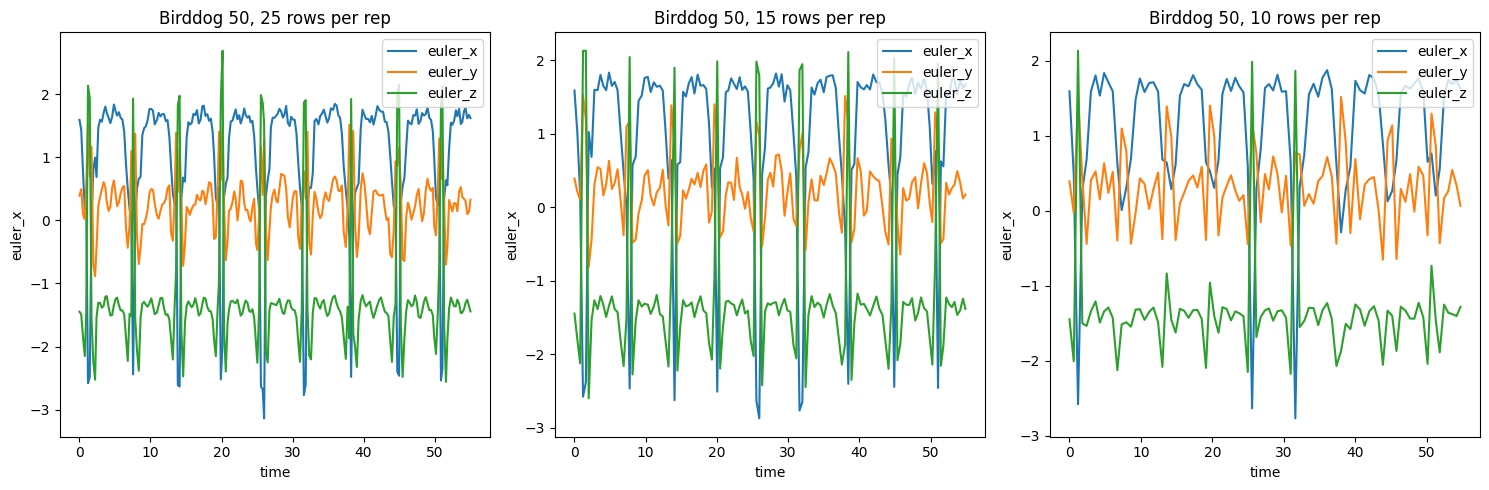

In [40]:
#plotting euler angles birddog

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=bd25, x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 50, 25 rows per rep')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=bd15, x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 50, 15 rows per rep')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=bd10, x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Birddog 50, 10 rows per rep')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()

There is definitely some detail lost moving down to 15 and a huge difference dropping down to 10 rows per rep. Will need to further investigate ways to avoid further reduction.

---

In [185]:
#viewing number of rows per rep in each data frame

from collections import defaultdict

row_counts = defaultdict(int)

for idx, df in enumerate(pushup_dataframes):
    # Count the number of rows for each repetition
    for rep_num, count in df['rep_num'].value_counts().items():
        row_counts[(idx, rep_num, count)] += 1

# Sort the results by the number of rows
sorted_row_counts = sorted(row_counts.items(), key=lambda x: x[0][2])

print("Repetitions Counted by Number of Rows (Sorted):")
for (df_idx, rep_num, count), repetition_count in sorted_row_counts:
    print(f"DataFrame {df_idx} - Rep Num {rep_num} with {count} rows: {repetition_count} occurrences")

Repetitions Counted by Number of Rows (Sorted):
DataFrame 2 - Rep Num 12 with 15 rows: 1 occurrences
DataFrame 2 - Rep Num 13 with 15 rows: 1 occurrences
DataFrame 38 - Rep Num 12 with 15 rows: 1 occurrences
DataFrame 75 - Rep Num 2 with 15 rows: 1 occurrences
DataFrame 75 - Rep Num 4 with 15 rows: 1 occurrences
DataFrame 134 - Rep Num 8 with 15 rows: 1 occurrences
DataFrame 134 - Rep Num 9 with 15 rows: 1 occurrences
DataFrame 159 - Rep Num 2 with 15 rows: 1 occurrences
DataFrame 159 - Rep Num 3 with 15 rows: 1 occurrences
DataFrame 2 - Rep Num 1 with 16 rows: 1 occurrences
DataFrame 2 - Rep Num 11 with 16 rows: 1 occurrences
DataFrame 2 - Rep Num 14 with 16 rows: 1 occurrences
DataFrame 35 - Rep Num 14 with 16 rows: 1 occurrences
DataFrame 38 - Rep Num 10 with 16 rows: 1 occurrences
DataFrame 38 - Rep Num 11 with 16 rows: 1 occurrences
DataFrame 44 - Rep Num 2 with 16 rows: 1 occurrences
DataFrame 44 - Rep Num 4 with 16 rows: 1 occurrences
DataFrame 44 - Rep Num 5 with 16 rows: 1 occ

In [184]:
#deleting data sets with limited number of rows per rep
'''
del pushup_dataframes[97]
'''

---

Selecting rows evenly by rep

In [187]:
# function to grab and even selection of values from each exercise rep

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 15
        entry_list = []

        for i in range(15):
            entry_list.append(round(i * interval))

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new

In [89]:
#same function as above leaving accomodation for reps that don't meet the row requirement, which I don't really want to do. But I'm using it for now while I tinker with things.

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 25
        entry_list = []

        for i in range(25):
            rounded_value = round(i * interval)
            if rounded_value < count:
                entry_list.append(rounded_value)

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new

In [332]:
#calling above function for each list of dataframes

armraise_reduced = [data_reduction_dataframe(df) for df in armraise_dataframes]
bicepcurl_reduced = [data_reduction_dataframe(df) for df in bicepcurl_dataframes]
birddog_reduced = [data_reduction_dataframe(df) for df in birddog_dataframes]
burpee_reduced = [data_reduction_dataframe(df) for df in burpee_dataframes]
crunch_reduced = [data_reduction_dataframe(df) for df in crunch_dataframes] #
hammercurl_reduced = [data_reduction_dataframe(df) for df in hammercurl_dataframes] 
overheadpress_reduced = [data_reduction_dataframe(df) for df in overheadpress_dataframes] #
pushup_reduced = [data_reduction_dataframe(df) for df in pushup_dataframes] #
tricepkickback_left_reduced = [data_reduction_dataframe(df) for df in tricepkickback_left_dataframes] #
tricepkickback_right_reduced = [data_reduction_dataframe(df) for df in tricepkickback_right_dataframes]
vup_reduced = [data_reduction_dataframe(df) for df in vup_dataframes]

In [333]:
len(tricepkickback_right_reduced[0])

210

In [227]:
#print the rows for the dataframe with the lowest number of rows. The lowest amount of rows in each grouping is 120.\
#So I will reduce all of the datasets to 120 rows, which will leave 8 reps per dataset.

sorted_dataframes = sorted(enumerate(birddog_final), key=lambda x: x[1].shape[0])

for i, (index, df) in enumerate(sorted_dataframes[:1]):
    print(f"DataFrame {index}: {df.shape[0]} rows")

DataFrame 0: 120 rows


In [334]:
def reduce_dataframes_to_120_rows(dataframes_list):
    reduced_dataframes = [df.head(120) for df in dataframes_list]
    return reduced_dataframes

In [335]:
#reducing all dataframes to 120 rows

armraise_final = reduce_dataframes_to_120_rows(armraise_reduced)
bicepcurl_final = reduce_dataframes_to_120_rows(bicepcurl_reduced)
birddog_final = reduce_dataframes_to_120_rows(birddog_reduced)
burpee_final = reduce_dataframes_to_120_rows(burpee_reduced)
crunch_final = reduce_dataframes_to_120_rows(crunch_reduced)
hammercurl_final = reduce_dataframes_to_120_rows(hammercurl_reduced)
overheadpress_final = reduce_dataframes_to_120_rows(overheadpress_reduced)
pushup_final = reduce_dataframes_to_120_rows(pushup_reduced)
tricepkickback_left_final = reduce_dataframes_to_120_rows(tricepkickback_left_reduced)
tricepkickback_right_final = reduce_dataframes_to_120_rows(tricepkickback_right_reduced)
vup_final = reduce_dataframes_to_120_rows(vup_reduced)

Now I need to reshape all of the dataframes so I can merge them all into one dataframe that I can apply a model to.

In [336]:
#function to flatten the data frames into single rows and them merge them into dataframe. Each row containing the data from 1 set of 8 reps
def process_dataframes(dataframes):
    result_df_list = []

    for df in dataframes:
        euler_columns = df[['euler_x', 'euler_y', 'euler_z']].values.flatten()
        new_df = pd.DataFrame([euler_columns], columns=[f"euler_{axis}_{i}" for i in range(1, len(euler_columns)//3 + 1) for axis in ['x', 'y', 'z']])
        first_row = df.iloc[0, :].drop(['euler_x', 'euler_y', 'euler_z'])

        result_df = pd.concat([first_row.to_frame().T, new_df], axis=1)
        result_df_list.append(result_df)

    final_result_df = pd.concat(result_df_list, ignore_index=True)
    return final_result_df

In [337]:
armraise = process_dataframes(armraise_final)
bicepcurl = process_dataframes(bicepcurl_final)
birddog = process_dataframes(birddog_final)
burpee = process_dataframes(burpee_final)
crunch = process_dataframes(crunch_final)
hammercurl = process_dataframes(hammercurl_final)
overheadpress = process_dataframes(overheadpress_final)
tricepkickback_left = process_dataframes(tricepkickback_left_final)
tricepkickback_right = process_dataframes(tricepkickback_right_final)
vup = process_dataframes(vup_final)

In [338]:
tricepkickback_left.shape

(98, 385)

In [339]:
#final merge to create dataframe with all the exercises

exercise_df = pd.concat([armraise, bicepcurl, birddog, burpee, crunch, hammercurl, overheadpress, tricepkickback_left, tricepkickback_right, vup], ignore_index=True)


In [340]:
exercise_df

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,rep_num,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,eul

Now that I have all my data in one place in a format I think I can use, its time to clean up the columns a little bit.

In [341]:
exercise_df['rep_num'].unique()

array([1], dtype=object)

In [342]:
exercise_df.shape

(1768, 385)

In [343]:
#dropping unnecessary columns
columns_to_drop = ['num_reps', 'trim_start_frac', 'trim_end_frac', 'kinematic_noise_factor', 'use_random_motion', 'randomize_body_shape', 'frames_per_second', 'image_width', 'image_height', 'seconds_per_rep', 'num_random_frames', 'rep_count_from_intermediate', 'rep_count_from_start', 'time', 'rep_num', 'random_seed']
exercise_df=exercise_df.drop(columns = columns_to_drop)

In [344]:
exercise_df.shape

(1768, 369)

Steps for modelling pipeline later?

In [351]:
#encoding categorical columns
columns_to_encode = ['exercise', 'watch_location', 'crown_orientation']

label_mappings = {}
enc = LabelEncoder()

for column in columns_to_encode:
    enc.fit_transform(exercise_df[column])
    
    exercise_df[f'{column}'] = enc.transform(exercise_df[column])
    label_mappings[column] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

# Display the label mappings
for column, mapping in label_mappings.items():
    print(f"Column: {column}")
    print("Original Label -> Encoded Value Mapping:")
    for label, encoded_value in mapping.items():
        print(f"  {label} -> {encoded_value}")
    print()

Column: exercise
Original Label -> Encoded Value Mapping:
  ARM_RAISE-DUMBBELL -> 0
  BICEP_CURL-DUMBBELL -> 1
  BIRD_DOG -> 2
  BURPEE -> 3
  CRUNCHES -> 4
  HAMMER_CURL-DUMBBELL -> 5
  OVERHEAD_PRESS-DUMBBELL -> 6
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-LEFT -> 7
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-RIGHT -> 8
  V_UP -> 9

Column: watch_location
Original Label -> Encoded Value Mapping:
  LEFT -> 0
  RIGHT -> 1

Column: crown_orientation
Original Label -> Encoded Value Mapping:
  LEFT -> 0
  RIGHT -> 1



In [352]:
exercise_df

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,ref_xy_rotation,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,euler_x_110,euler_y_110,euler_z_110,euler_x_111,euler_y_111,euler_z_111,euler_x_112,euler_y_112,euler_z_112,euler_x_113,euler_y_113,euler_z_113,euler_x_114,euler_y_114,euler_z_114,euler_x_115,euler_y_115,euler_z_115,euler_x_116,euler_y_116,euler_z_116,eul

In [353]:
non_numeric_columns = exercise_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['ref_xy_rotation', 'rel_baseline_speed', 'max_rel_speed_change',
       'wrist_offset_deg', 'ref_xy_rotation', 'avg_rep_time'],
      dtype='object')


In [354]:
#don't judge me, this worked and my less wordy version wasn't working and I'm tired :D
exercise_df['ref_xy_rotation'] = exercise_df['ref_xy_rotation'].astype(float)
exercise_df['rel_baseline_speed'] = exercise_df['rel_baseline_speed'].astype(float)
exercise_df['max_rel_speed_change'] = exercise_df['max_rel_speed_change'].astype(float)
exercise_df['wrist_offset_deg'] = exercise_df['wrist_offset_deg'].astype(float)
exercise_df['ref_xy_rotation'] = exercise_df['ref_xy_rotation'].astype(float)
exercise_df['avg_rep_time'] = exercise_df['avg_rep_time'].astype(float)

In [355]:
exercise_df.iloc[:, :10].describe()


,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,ref_xy_rotation,avg_rep_time,euler_x_1
count,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000
mean,4.161765,0.498869,0.500566,3.075143,1.140106,0.159040,-0.552157,3.075143,2.844651,0.005314
std,2.856672,0.500140,0.500141,1.810480,0.388024,0.120412,18.833785,1.810480,2.364977,1.824003
min,0.000000,0.000000,0.000000,0.000068,0.500301,0.000028,-44.753317,0.000068,0.773077,-3.134623
25%,2.000000,0.000000,0.000000,1.516402,0.846894,0.060804,-14.723011,1.516402,1.522045,-1.437962
50%,4.000000,0.000000,1.000000,3.051973,1.103707,0.134453,-0.955696,3.051973,2.094097,0.037029
75%,6.000000,1.000000,1.000000,4.603642,1.391872,0.226439,13.541870,4.603642,3.087500,1.412526
max,9.000000,1.000000,1.000000,6.278917,2.861832,0.777604,44.344465,6.278917,16.791667,3.139900


## Learning about Fourier Transform

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ \
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

In [20]:
import pandas as pd
import numpy as np
from scipy.fft import fft

df2 = armraise_dataframes[0]

euler_columns = ['euler_x', 'euler_y', 'euler_z']

# Apply Fourier transform to each column
for col in euler_columns:
    euler_array = np.ascontiguousarray(df2[col].values)
    
    df2[f'{col}_fft'] = np.abs(fft(euler_array))


In [21]:
df2

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,euler_x,euler_y,euler_z,euler_x_fft,euler_y_fft,euler_z_fft
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,4.818261,0.00,-0.085816,-1.236302,0.301816,233.448722,164.943182,104.794592
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,4.818261,0.05,-0.068092,-1.232152,0.282132,0.427206,5.311859,17.004060
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,4.818261,0.10,-0.038189,-1.221286,0.252032,11.860372,21.937540,60.676702
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,4.818261,0.15,-0.001822,-1.203772,0.216632,0.547906,14.878555,56.158340
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,4.818261,0.20,0.042375,-1.174680,0.175925,28.460837,16.318868,17.178685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.370983,11.897299,4.818261,35.45,0.068727,-1.028733,-0.003188,13.197612,1.616661,10.294815
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.387749,11.914065,4.818261,35.50,0.030103,-1.093677,0.032537,28.460837,16.318868,17.178685
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.404509,11.930825,4.818261,35.55,-0.010567,-1.139929,0.073019,0.547906,14.878555,56.158340
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.421261,11.947576,4.818261,35.60,-0.061702,-1.173829,0.124910,11.860372,21.937540,60.676702


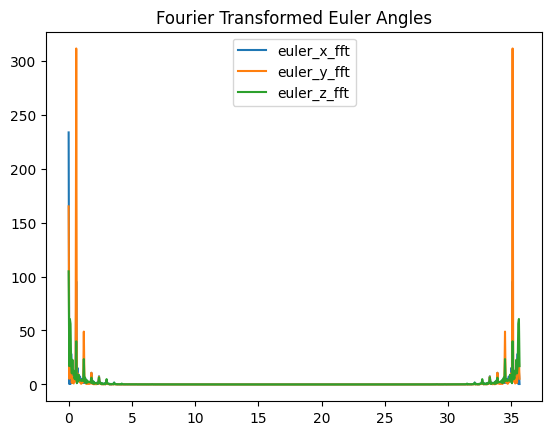

In [37]:
import matplotlib.pyplot as plt

# Assuming df2 is your DataFrame with Fourier-transformed columns
euler_fft_columns = ['euler_x_fft', 'euler_y_fft', 'euler_z_fft']

# Plot each Fourier-transformed column
for col in euler_fft_columns:
    plt.plot(df2['time'], df2[col], label=col)

plt.legend()
plt.title('Fourier Transformed Euler Angles')

# Show the plot
plt.show()

.